# Classifying Wikipedia Comments with BERT

By Chris McCormick & Nick Ryan



This Notebook will show you how to fine-tune BERT for **multi-label text classification** tasks, meaning that each sample in the dataset can belong to more than one category (or no category!).

We'll be using the *Wikipedia Toxic Comments Challenge* dataset, which contains a large number of user-written comments, and where each comment can be tagged with multiple labels.

The dataset has **6** different labels corresponding to different types of awfulness ("toxic", "obscene", "insult", ...), and each comment can be tagged with one or more labels, or no labels at all.

This is a slightly different task than "multiclass" classification, where there are multiple categories, but each sample only belongs to one category.

> *Side Note: Going off of the Wikipedia article titles, the correct spelling for these two terms are "[Multiclass](https://en.wikipedia.org/wiki/Multiclass_classification)" and "[Multi-label](https://en.wikipedia.org/wiki/Multi-label_classification)", so I'll do my best to stick to those spellings :)*

The huggingface `transformers` library has built-in support for multiclass, but not multi-label, so we'll be defining a custom class here to do it! (Note that we'll still be relying heavily on the `transformers` library).

> Note that Kaushal Trivedi has previously created and shared this same example [here](https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d) back in 2019--modifying PyTorch transformers to apply it to the toxic comments challenge. His example code isn’t well documented, though, so we didn’t use it as the basis for our example here, other than to help confirm the small changes we needed to make to the model. That said, his code may be a source of additional insight if you are interested. For instance, he appears to use a more complex learning rate scheduler than the linear one that we have been using in our examples.



## Notebook Access


-------------------------------------

[![Notebook Access](https://drive.google.com/uc?export=view&id=1yPJapK5X9kXLDhtuDJm3Hw4-ZlxMwcsa)](https://www.chrismccormick.ai/membership)

<sup>\*</sup>Notify me [here](team@chrismccormick.ai)

<sup>\*\*</sup>Join my site [here](https://www.chrismccormick.ai/membership)

---------------------------------------



## Overview



This Notebook is divided into six sections.

* Section 1 - We'll look at the differences in a multi-label vs. multi-class architecture, and we'll define our custom multi-label model, using `transformers` and PyTorch.
* Section 2 - We'll retrieve the toxic comments dataset and explore it a bit.
* Section 3 - We'll tokenize the dataset so that it's ready to be fed into BERT.
* Section 4 - We'll implement and run our training loop to fine-tune BERT on this dataset.
* Section 5 - We'll apply our fine-tuned model to the test set of the toxic comments challenge and see how well we score!



## S1. Defining our Multi-Label Model

In all of our examples, we have been using the `transformers` library by Huggingface, because it defines models for us for several different NLP tasks. Here are the most significant ones:

* `BertForSequenceClassification` - Binary and Multiclass Text Classification.
* `BertForTokenClassification` - Token-level classification, such as for Named Entity Recognition (NER)
* `BertForQuestionAnswering` - Identify a span of text within a passage which answers the posed question.

Each of these classes places a different final layer on top of the BERT model depending on the task.

The `BertForSequenceClassification` class is the closest to what we are looking for; for some reason, though, it does not support multi-label classification, and so we'll need to define our own model: **BertForMultiLabelSequenceClassification**.

Fortunately, we'll see that it's a pretty small change from the existing `BertForSequenceClassification`. To understand the change, let's look at the difference in architectures.



### 1.1. Multiclass vs. Multi-Label Architectures


At the most basic level, in *multiclass* our target is a one-hot vector that must have one and only one positive class. For multi-label our target is a one-hot vector that can have a) no positive classes, b) one positive class, or c) multiple positive classes.



![One Hot Vectors](https://drive.google.com/uc?id=1cPFTlbBVT9I2wx06M1MkuAToXfpXruuS)



In both cases, the embedding for the `[CLS]` token, after being "enhanced" by all 12 of BERT's encoder layers, is fed into a classifier which makes our predictions.



![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)




The difference between how we handle multilabel vs multiclass tasks is just in the classifier at the very end!

In both cases, we use a simple linear classifier, which has a `[768 x 6]` weight matrix. We multiply the `[CLS]` embedding (length 768) against this matrix to produce 6 logit values (one for each class).

The difference between multiclass and multi-label is what we do with those 6 logits--we use a different *activation function* and *loss function*.



#### Multiclass


For multiclass, we use the **SoftMax activation** function with **Cross-Entropy Loss**. You'll sometimes see this classifier referred to as a "SoftMax Regression" classifier (the use of the term 'regression' to name a classifier is confusing, I know!).

The below illustration shows how the final `[CLS]` token embedding is multiplied by the classifier weights to produce the logits, then sent through the SoftMax activation function.


![Multiclass Classifier with SoftMax](https://drive.google.com/uc?id=1X4hGAlKoTkoQlbLx3w2Iye3QaOIOuecQ)


The result is a distribution of scores across the classes that will always add up to 1.0.

Using softmax, the probability of one class affects the probability of the other classes in a big way. This works out well because there is only one correct answer, so if one score is very likely we want to make the other scores very unlikely.

When we want to predict the label for a new piece of input text, we simply assign it the highest scoring class.



#### Multi-Label


For multi-label, this presents a problem. Since an example can belong to multiple classes, we don't want the high probability that our example is one class to negatively affect the probability that it could be in the other classes.

For multilabel, we will use the **sigmoid activation** function with **Binary Cross-Entropy Loss**.

Here is the same illustration, this time with sigmoid activation.



![Multilabel Classifier with sigmoid](https://drive.google.com/uc?id=1XAJfd9pVAIqIX43Ih13X4d4DjWEe7tys)



When we want to predict the labels for a new piece of input text, we just assign all labels whose scores are greater than some threshold. The sigmoid function always outputs values in the range 0 - 1.0, so 0.5 is a reasonable choice for our threshold.





#### Summing Up


**Multiclass = SoftMax + Cross-Entropy**

**Multi-Label = Sigmoid + Binary Cross-Entropy**

**SoftMax** = Squish the outputs into a probability distribution of scores that add up to 1.

**Sigmoid** = Squish each output into a score between 0 and 1.

**Cross-Entropy Loss** = Punishes bad predictions at log scale.



### 1.2. Install the Hugging Face Library


With the theory out of the way, now we can define our new architecture in code.

We will still be relying heavily on the `transformers` library, so we'll need to install it before we can define our model.

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 25.9MB/s 
     |████████████████████████████████| 3.0MB 32.5MB/s 
     |████████████████████████████████| 890kB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6157a056fa22133686957db951386dc9ca21abd1b203f7eac0ecdbd228cedee2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### 1.3. BertForMultiLabelSequenceClassification

Now it's time to implement our custom model!

> *If you're not interested in the details of implementing models in PyTorch, feel free to skip this section--you can always return to it later.*

We can get most of what we need for our model definition by simplying copying the source code for `BertForSequenceClassification` from `modeling_bert.py` [here](https://github.com/huggingface/transformers/blob/0735def8e1200ed45a2c33a075bc1595b12ef56a/src/transformers/modeling_bert.py#L1267).

`BertForSequenceClassification` calls down to an instance of `BertModel`, which implements all of BERT's non-task-specific architecture. We just need to define a `forward` function which calls down to `BertModel`, and then adds on our final multi-label classification step.

I've commented our "BertFor**MultiLabel**SequenceClassification" class in detail below, but here is the outline of what happens in the call to `forward`:

1. The inputs are passed through an instance of `BertModel`, which returns the final `[CLS]` token embedding that we need for classificaiton.
2. The `[CLS]` embedding is multiplied by a `[768 x 6]` weight matrix (our classifier weights), which produces our 6 output "logits".
3. During **evaluation**, that's it! We return the logits as our predictions.
4. During **training**, we feed the logits through an instance of `BCEWithLogitsLoss` from PyTorch, which:
    1. Applies the sigmoid activation function to each of the 6 logit values.
    2. Sends these final activations, along with the correct labels, through the Binary Cross-Entropy Loss function to calculate the "loss" (how well / poorly the model is predicting the correct labels).

And that's it!

Finally, note that we'll be using a batch size of 16 in this Notebook, so I use that as an example value in some of the comments below.


***Aside: What about implementing backprop?***

PyTorch handles gradient calculation for us--it constructs a "compute graph" as we execute the forward pass, attaching the graph to the tensors we use, and is able to automatically calculate our gradients from that graph when we call `loss.backward()` in our training loop.

The actual weight updates are performed in the training loop later in the Notebook when we call `optimizer.step()`.


BertFor**MultiLabel**SequenceClassification

In [ ]:
from torch import nn
from torch.nn import BCEWithLogitsLoss
from transformers import BertPreTrainedModel, BertModel

class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    '''
    This custom class closely resembles BertForSequenceClassification, which
    supports multiclass classification, but not multi-label.
    This modified version supports data points with multiple labels.
    '''

    def __init__(self, config):
        '''
        Class initializer, called when we create a new instance of this class.
        '''

        # Call the init function of the parent class (BertPreTrainedModel)
        super().__init__(config)

        # Store the number of labels.
        self.num_labels = config.num_labels

        # Create a `BertModel`--this implements all of BERT except for the final
        # task-specific output layer (which is what we'll do here in `forward`).
        self.bert = BertModel(config)

        # Setup dropout object (note: I'm not familiar enough to speak to this).
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Create a [768 x 6] weight matrix to use as our classifier.
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize model weights (inherited function).
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        '''
        This function defines what happens on a forward pass of our model, both
        for training and evaluation. For example, when we call
            `model(b_input_ids, ...)`
        during our training loop, it results in a call to this `forward`
        function.
        '''

        # ====================
        #   Run Through BERT
        # ====================

        # All of BERT's (non-task-specific) architecture is implemented by the
        # BertModel class. Here we pass all of the inputs through our BertModel
        # instance.
        outputs = self.bert(
            input_ids,                      # The input sequence
            attention_mask=attention_mask,  # Mask out any [PAD] tokens.
            token_type_ids=token_type_ids,  # Identify segment A vs. B
            position_ids=position_ids,      # TODO...
            head_mask=head_mask,            # TODO...
            inputs_embeds=inputs_embeds,    # Presumably the initial embeddings
                                            # for the tokens in our sequence.
            output_attentions=output_attentions, # Boolean, whether to return
                                                 # all of the attention scores.
            output_hidden_states=output_hidden_states, # Whether to return
                                                       # embeddings from all 12
                                                       # layers.
        )

        # Side note: It confused me to see us *invoking* an instance of a class
        # (calling self.bert(...)) as if it were a function! I learned that in
        # Python, an instance of a class can be callable if the class defines a
        # `__call__` method!
        # BertModel ultimately inherits from torch.nn.Module, which I imagine
        # implements a `__call__` method that allows PyTorch to work its magic.

        # The forward pass of 'BertModel' (the call to `self.bert`) returns two
        # items.

        # The first output is the final embeddings taken from the output of
        # the final BERT encoder layer.
        #
        # `final_embeddings` has dimensions:
        #    [ batch size  x  sequence length  x  768]
        #      (768 is the length of the embeddings in BERT-base)
        #
        # I've included this here for informational purposes, but we won't
        # actually use the `final_embeddings` anywhere here!
        final_embeddings = outputs[0]

        # ===========================
        #   Apply Output Classifier
        # ===========================

        # The second output is the activated form of the final [CLS] embedding.
        # This comes from the so-called "pooling layer" that BERT has on its
        # output which is only applied to the [CLS] token and none of the
        # others.
        #
        # You can see the definition of BertPooler.forward here:
        # https://github.com/huggingface/transformers/blob/0735def8e1200ed45a2c33a075bc1595b12ef56a/src/transformers/modeling_bert.py#L506
        #
        # It takes the final embedding for the [CLS] token (and *only* that
        # token), multiplies it with a [768 x 768] weight matrix, and then
        # applies tanh activation to each of the 768 features in the embedding.
        activated_cls = outputs[1]

        # Apply dropout (note: I'm not familiar enough with dropout to speak to
        # it, but I believe it is applied during training only, and is turned
        # off during evaluation mode when we call `model.eval()`).
        activated_cls = self.dropout(activated_cls)

        # Send it through our linear "classifier". The "classifier" is actually
        # just a [768 x 6] weight matrix, with *no activation function*.
        # Multiplying the activated CLS embedding with this matrix results in
        # a vector with 6 values, which are the scores for each of our classes.
        # Because we have not applied the activation function, these output
        # values are referred to as "logits".
        # When performing evaluation (not training), the logits are adequate for
        # making a classification, since the activation function does not change
        # the ranking of the results.
        # So, in evaluation mode, we are done here!
        logits = self.classifier(activated_cls)

        # ===================
        #   Training Mode
        # ===================

        # If labels for the inputs have been provided, we take that to mean that
        # we are in training mode, and we need to calculate the loss function.
        if labels is not None:

            # The Binary Cross-Entropy Loss function is defined for us in
            # PyTorch by the `BCEWithLogitsLoss` class.
            #
            # This loss function will:
            #   1. Apply the sigmoid activation to each of our 6 logit values.
            #   2. Feed those outputs, along with the correct labels, through
            #      the binary cross entropy loss function to calculate a
            #      (single?) loss value for the sample.
            loss_fct = BCEWithLogitsLoss()

            # Call the loss function, giving it the `logits` and the correct
            # `labels`.
            loss = loss_fct(logits.view(-1, self.num_labels), # The logits
                            labels.view(-1, self.num_labels)) # The labels

            # What's view(-1, ...)?
            # The `view` function is used to reshape tensors. `-1` tells PyTorch
            # to infer that dimension by dividing the total number of elements
            # by the other dimensions.
            # For batched input, this call to view is not necessary. Both
            # `logits` and `labels` are already [16 x 6] here.
            # Perhaps it's there to re-shape the tensors if you're only
            # evaluating on a single input instead of a batch?

            # Output is (loss, logits, <bonus returns>)
            # The 'bonus return' values are the attentions and the hidden states
            # from all 12 layers, but these are only returned by `BertModel` if
            # the appropriate flags are set.
            return ((loss, logits) + outputs[2:])

        # ===================
        #   Evaluation Mode
        # ===================

        # Otherwise, in evaluation mode...
        else:

            # Output is (logits, <bonus returns>)
            # Again, the logits are adequate for classification, so we don't
            # bother applying the (sigmoid) activation function here.
            return ((logits,) + outputs[2:])

## S2. Retrieve & Inspect Dataset



The Toxic Comments Challenge on Kaggle (TODO) tasks competitors with classifying user-written comments (from Wikipedia edit pages) as containing depending on whether they
toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405

### 2.1. Download
--------------------------------------
Download the text.

In [ ]:
import gdown
import os

# Model files and their Google Drive IDs.
# These are tuples of the form (local_file_name, drive_id).

files = [
     ('./data/train.csv',     '1kacByJji9j_dzVcuV8Dl7sZKH0pLkwZZ'),
     ('./data/test.csv',     '1ZkfmPRFiEVuZ2GlNKw3tZZkn9WwxqADp'),
     ('./data/sample_submission.csv', '1QPw2EaY3mKqcMcQYss6FebJXtCRMHN-1'),
     ('./data/test_labels.csv', '18Pkeuvm8_6c2iz-vymM8FZ5dyMUONU1j'),
]

# Make the '/data/' subdirectory.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

print('Downloading dataset files...')

# For each of the files...
for pair in files:
    # Get the local filename.
    output = pair[0]

    # Get the ID of the file on Google Drive.
    file_id = pair[1]

    # Download the file.
    gdown.download('https://drive.google.com/uc?id=' + file_id, output,
                   quiet=False)

print('DONE.')

Downloading...
From: https://drive.google.com/uc?id=1kacByJji9j_dzVcuV8Dl7sZKH0pLkwZZ
To: /content/data/train.csv
68.8MB [00:00, 119MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ZkfmPRFiEVuZ2GlNKw3tZZkn9WwxqADp
To: /content/data/test.csv
60.4MB [00:00, 86.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPw2EaY3mKqcMcQYss6FebJXtCRMHN-1
To: /content/data/sample_submission.csv
6.28MB [00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Pkeuvm8_6c2iz-vymM8FZ5dyMUONU1j
To: /content/data/test_labels.csv
4.98MB [00:00, 173MB/s]

DONE.


### 2.2. Parse & Inspect
-------------------



We'll use `pandas` just to help us parse the comma-separated `.csv` file.


In [ ]:
import pandas as pd
train = pd.read_csv('./data/train.csv')


The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


There are roughly 160k training examples.

In [ ]:
print('There are {:,} training examples.'.format(len(train)))

There are 159,571 training examples.


Display some of the comments labeled as containing an attack. Be prepared to see some terrible human behavior... (I've removed the output for this cell!)

In [ ]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

# Filter to just the "insult" comments.
insults = train.loc[train.insult == 1]['comment_text']
comments = train.loc[train.insult == 1]['comment_text']

# Randomly choose some examples.
for i in range(5):
    j = random.choice(insults.index)

    print('')
    print(wrapper.fill(insults[j]))
    print('')


### 2.3. Class Distribution

To analyze the distribution of the labels, let's first explicitly flag the comments which are not toxic (have no labels set to 1).

In [ ]:
# These are the six possible labels.
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Select just the labels (not the text), and for every row, check whether any
# of the labels are "1".
has_labels = train[label_cols].any(axis=1)

# Add a new column indicating which samples have no toxic labels.
train['none'] = 1 - has_labels

# Add the 'none' column to our list of label names.
label_cols.append('none')

Total the number of samples with each label.

In [ ]:
# Tally up each label separately.
label_counts = train[label_cols].sum(axis=0)

print(label_counts)

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64


So what percentage are toxic in some way?

In [ ]:
print('{:.1%} of the comments are safe.'.format(label_counts['none'] / len(train)))

89.8% of the comments are safe.


How many samples are there of each type?


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, '# of Training Samples')

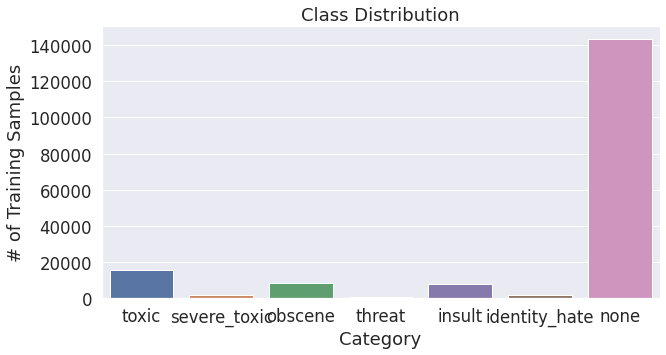

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the number of tokens of each length.
sns.barplot(x=label_cols, y=label_counts)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')


Based on the above, if we just predicted "not toxic" for *every single training sample*, we would get ~90% accuracy on the training set! So we'll have to be careful in how we interpret our accuracy on this task to make sure we're actually doing better than this.

## S3. Tokenization & Truncation

We'll need to tokenize all of the text in our dataset, using BERT's own tokenizer, in order to feed the text into BERT for training.

Before we do that, we have an important decision to make about the maximum "sequence length" (the number of tokens in an input sentence/passage). BERT is limited to a maximum input length of 512 tokens. Beyond that, long input sequences mean long training times and potential GPU memory issues.

For these reasons, we'll be truncating some of the text samples to a shorter length. To decide on this length, we'll start by exploring the lengths of the text samples in our dataset.


### 3.1. Load BertTokenizer


In order to see the distribution of comment lengths *in terms of BERT tokens*, we'll need to first apply the BertTokenizer to the dataset.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### 3.2. Comment Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of comment lenghts.

> **NOTE:** To save time, you can skip running the cells in section 3.2. (But still read through it, of course!)

To do this, our first step is to tokenize all of the comments in the training set using the `tokenizer.encode` function.

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Later, we will use the `tokenizer.encode_plus` function, which will perform truncation and padding for us! Here, though, we just want to see the *unmodified* sequence lengths.


In [ ]:
import numpy as np
import logging

# By default, the tokenizer will spit out a warning whenever we tokenize a
# sample which ends up being more than 512 tokens. We don't care about that for
# now, though, and this cell will produce a lot of those warnings! So we'll
# adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for index, row in train.iterrows():

    # Report progress.
    if ((len(lengths) % 20000) == 0):
        print('  Tokenized {:,} comments.'.format(len(lengths)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        row['comment_text'],     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')

Tokenizing comments...
  Tokenized 0 comments.
  Tokenized 20,000 comments.
  Tokenized 40,000 comments.
  Tokenized 60,000 comments.
  Tokenized 80,000 comments.
  Tokenized 100,000 comments.
  Tokenized 120,000 comments.
  Tokenized 140,000 comments.
DONE.


Let's grab some quick statistics--what are the min, max and median comment lengths?

In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 4 tokens
   Max length: 4,950 tokens
Median length: 52 tokens


To further analyze it, let's plot the distribution. To keep the scale of the x-axis reasonable, *we'll clip the lengths to 512.*


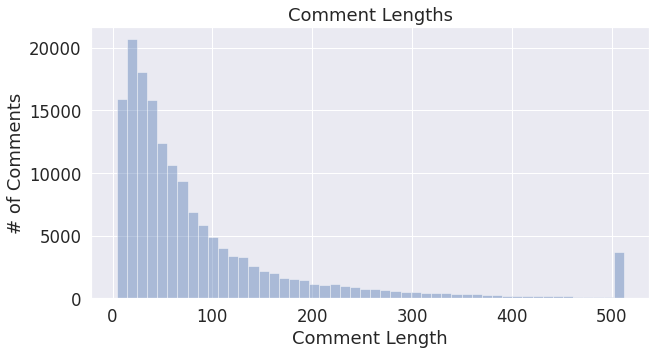

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(trunc_lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

plt.show()

Clearly the majority of the comments are relatively short. Let's count up how many comments would be truncated based on different choices of `max_len`.

In [ ]:
import numpy as np

# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 400, 512]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print('max_len = {:}  -->  {:>7,} of {:>7,}  ({:>5.1%})  ' \
          'will be truncated '.format(
              max_len, num_over, num_comments, prcnt_over
          ))

How many comments will be truncated?

max_len = 128  -->   30,790 of 159,571  (19.3%)  will be truncated 
max_len = 256  -->   11,063 of 159,571  ( 6.9%)  will be truncated 
max_len = 300  -->    8,446 of 159,571  ( 5.3%)  will be truncated 
max_len = 400  -->    5,159 of 159,571  ( 3.2%)  will be truncated 
max_len = 512  -->    3,523 of 159,571  ( 2.2%)  will be truncated 


### 3.3. Choose max_len

There are several factors that impact our choice of the maximum sequence length `max_len`:
1. **Training Time** - Training time is quadratic with `max_len`. `max_len = 512` will take 4x  longer to train than `max_len = 256`, and 16x longer than `max_len = 128`!
2. **Accuracy** - Truncating the samples to a shorter length will presumably hurt accuracy, due to the loss of information. How much it hurts depends on the dataset, though--in a previous Notebook ([Document Classification](https://colab.research.google.com/drive/1iWrcYR_kG_6yGbCZJ0qqgaOigYlW9qc8#scrollTo=Qxi0mOhbmRLi)) which worked with the two-class version of this Wikipedia comments dataset, we found that truncation had little impact on our score.
3. **GPU Memory** - The combination of `max_len` and `batch_size` need to fit within the memory limits of our GPU. We explored this limit in a previous Notebook ([Multiclass Classification](https://colab.research.google.com/drive/1iWrcYR_kG_6yGbCZJ0qqgaOigYlW9qc8#scrollTo=Qxi0mOhbmRLi)). For a Tesla K80 (which has 12GB of RAM!), with `batch_size = 16`, the maximum length we can use (without running of memory) is about `max_len = 400`.

For this notebook, we'll use **`max_len = 128`** to speed up training times, and we'll see that BERT still delivers high accuracy on this benchmark, despite the truncation.



In [ ]:
# Set our sequence length to pad or truncate all of our samples to.
max_len = 128

### 3.4. Tokenize Dataset


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.
6. Cast everything to pytorch tensors.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Optional - You can select a subsample of the dataset to run through the
#            Notebook quicker.
if False:
    # Take just the first 4,000 training samples.
    train = train[:4000]

In [ ]:
import torch
import time

input_ids = []
attn_masks = []
labels = []

t0 = time.time()

# ======== Encoding ========

print('Encoding {:,} training examples...'.format(len(train)))

# For every training example...
for (index, row) in train.iterrows():

    # Report progress.
    if ((len(input_ids) % 15000) == 0):
        print('  Encoded {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])

print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# ======== Prepare Labels ========

# Select the label columns for all examples.
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))

print('\nEncoding took {:.0f} seconds'.format(time.time() - t0))

Encoding 159,571 training examples...
  Encoded 0 comments.
  Encoded 15,000 comments.
  Encoded 30,000 comments.
  Encoded 45,000 comments.
  Encoded 60,000 comments.
  Encoded 75,000 comments.
  Encoded 90,000 comments.
  Encoded 105,000 comments.
  Encoded 120,000 comments.
  Encoded 135,000 comments.
  Encoded 150,000 comments.

DONE. 159,571 examples.

Data structure shapes:
   input_ids:  torch.Size([159571, 128])
  attn_masks:  torch.Size([159571, 128])
      labels:  torch.Size([159571, 6])

Encoding took 229 seconds


### 3.5. Split-Off a Validation Set

This dataset already has separate training and test sets, but we're going to further divide up our training set to use 90% for training and 10% for *validation*. This validation set will help us detect over-fitting during the training process.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attn_masks, labels)

# Create a 90-10 train-validation split. Calculate the number of samples to
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## S4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

### 4.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### 4.1. Initialize Model with Pre-Trained Weights

In [ ]:
from transformers import AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForMultiLabelSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

print ("Model loaded.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

Model loaded.


### 4.4. Batch Size & DataLoaders

We'll also create a PyTorch DataLoader for our dataset.

The DataLoader simply handles the creation of training batches for us.

**Choice of Batch Size**

Training on a small batch of training samples at once (rather than one sample at a time) makes more efficient use of our GPU's parallel processing capabilities, and seems to even improve the model's accuracy.

The BERT authors recommend trying a batch size of either 16 or 32. For this Notebook, we'll be using a **batch size of 16**.

**Randomization**

The DataLoader for our training set will construct batches for us by randomly selecting different samples to put in each batch (each training sample will only appear in one batch, though!).

Randomizing the training samples is considered good practice. Moreover, I believe the randomization is re-done for each training epoch (each pass through our training set), and that this can improve model accuracy.

For validation, it doesn't matter what order we execute in.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 4.5. Optimizer

Our `model` object handles the execution of a forward pass, and the calculation of gradients during training.

The actual updates to the model's weights, however, are performed by an Optimizer object. Here, we create that object and give it a reference to our model's parameters, as well as set some of our training hyperparameters.

For the purposes of fine-tuning, the authors recommend the following choices of learning rates: 5e-5, 3e-5, 2e-5  (We'll use 2e-5).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

### 4.6. Epochs & Learning Rate Scheduler

The learning rate scheduler is responsible for updating the learning rate over the course of the training. Generally speaking, you want the learning rate to gradually get smaller and smaller so that training makes gradually finer adjustments to the weights.

This decay needs to happen *across all of the training epochs*, so this is where we need to specify the number of epochs we want to train for.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (BERT authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

**Helper Functions**

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Helper function to automatically pick a reasonable interval for printing out a progress update during training.

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

Submissions for the Toxic Comments Challenge are evaluated "on the mean column-wise ROC AUC". In other words, the score is the average of the individual AUCs of each predicted column.

This is accomplished by setting `average='macro'` in our call to the `roc_auc_score` function from scikit-learn.

In [ ]:
from sklearn.metrics import roc_auc_score

# A quick example...
true_labels = [0,1,0,0,1]
pred_labels = [0,1,0,0,0]

score = roc_auc_score(true_labels, pred_labels, average='macro')

print('Example ROC AUC score:', score)

Example ROC AUC score: 0.75


### 4.7. Training loop



In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0

    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():


            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the validation accuracy.
    val_accuracy = roc_auc_score(flat_true_labels, flat_predictions, average='macro')

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:05:43.
  Batch 1,800  of  8,976.    Elapsed: 0:11:31.
  Batch 2,700  of  8,976.    Elapsed: 0:17:20.
  Batch 3,600  of  8,976.    Elapsed: 0:23:07.
  Batch 4,500  of  8,976.    Elapsed: 0:28:55.
  Batch 5,400  of  8,976.    Elapsed: 0:34:42.
  Batch 6,300  of  8,976.    Elapsed: 0:40:30.
  Batch 7,200  of  8,976.    Elapsed: 0:46:17.
  Batch 8,100  of  8,976.    Elapsed: 0:52:04.

  Average training loss: 0.05
  Training epcoh took: 0:57:42

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.04
  Validation took: 0:02:13

======== Epoch 2 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:05:47.
  Batch 1,800  of  8,976.    Elapsed: 0:11:35.
  Batch 2,700  of  8,976.    Elapsed: 0:17:24.
  Batch 3,600  of  8,976.    Elapsed: 0:23:13.
  Batch 4,500  of  8,976.    Elapsed: 0:29:02.
  Batch 5,400  of  8,976.    Elapsed: 0:34:50.
  Batch 6,300  of  8,976.    Elapsed: 0:40:39.
  Batch 7

### 4.8. Training Results

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.05,0.04,0.99,0:57:42,0:02:13
2,0.03,0.04,0.99,0:57:56,0:02:14
3,0.02,0.04,0.99,0:57:56,0:02:14


We can plot the training loss and validation loss to check if our model is overfitting.

> When checking for over-fitting, loss is a better indicator than accuracy. Accuracy only takes into account whether the model's output was on the correct side of the decision threshold, whereas loss also incorporates the model's *confidence*.

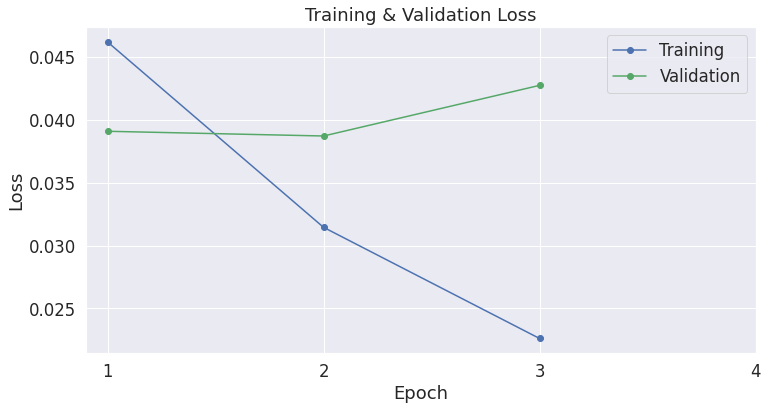

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Looks like we're over-fitting a bit on the third epoch.

## S5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

### 5.1. Prepare Test Set

The test set contains 153,164 samples, but only includes labels for 63,978 of them. In the challenge description, they explain that this was done to "discourage hand-labeling".

In [ ]:
# Load the test set files.
test = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')

print('There are {:,} total test examples.'.format(len(test)))

# The unlabeled test samples are indicated by all of the label values being
# "-1" for that sample.

# Select only the labeled test samples.
test = test[test_labels.toxic != - 1]
test_labels = test_labels.loc[test_labels.toxic != -1]

print('There are {:,} labeled test examples.'.format(len(test)))

**Tokenize & Encode**

Encode the test set, using the same code from 3.4.

In [ ]:
import torch

input_ids = []
attn_masks = []
labels = []

# ======== Encoding ========

print('Encoding all {:,} test samples...'.format(len(test)))

# For every test sample...
for (index, row) in test.iterrows():

    # Report progress.
    if ((len(input_ids) % 5000) == 0):
        print('  Tokenized {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])

print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)


In [ ]:

# ======== Prepare Labels ========

# Remove the 'id' column.
#test_labels = test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
del test_labels['id']

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = test_labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))

**DataLoader**

Create a DataLoader to batch our test samples for us.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attn_masks, labels)

# Specify our batch size.
batch_size = 16

# Create the DataLoader, which will select batches for us. For testing, the
# order we evaluate the samples in doesn't matter, so we'll just use the
# "SequentialSampler" to read them in order.
test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


### 5.2. Evaluate On Test Set

In [ ]:
import time

# Prediction on test set

# Put model in evaluation mode
model.eval()

t0 = time.time()

# Tracking variables
predictions , true_labels = [], []

print('Evaluating on {:,} test set batches...'.format(len(test_dataloader)))

# Predict
for batch in test_dataloader:

    # Report progress.
    if ((len(predictions) % 500) == 0):
        print('  Batch {:>5,}  of  {:>5,}.'.format(len(predictions), len(test_dataloader)))

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store the compute graph, saving memory
    # and speeding up prediction
    with torch.no_grad():

        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

print('Evaluation took {:.0f} seconds.'.format(time.time() - t0))

We collected the predictions in batches, so now we just need to recombine them.

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

### 5.3. Score Results

Let's take a look at the model outputs for one of the test samples.

Most samples don't contain anything toxic, so let's find one that actually does.

In [ ]:
# For every test sample...
for test_i in range(0, len(test)):

    # Break if it has at least one label set.
    if np.any(flat_true_labels[test_i, :]):
        break

print('Test sample: {:,}\n'.format(test_i))

Test sample: 8



Now we can look at the model's predictions vs. the correct labels for this test sample.

In [ ]:
# Print out model predictions vs. correct values for this test sample.
print('           Type   Output   Truth')
print('           ----   ------   -----')

for label_i in range(0, 6):
    print('{:>15}   {:>5.2f}      {:}'.format(
        label_cols[label_i], # Label name
        flat_predictions[test_i, label_i], # Model's prediction
        int(flat_true_labels[test_i, label_i]))) # Correct label


           Type   Output   Truth
           ----   ------   -----
          toxic    4.05      1
   severe_toxic   -4.55      0
        obscene   -3.39      0
         threat   -3.10      0
         insult   -1.96      0
  identity_hate   -0.35      0


Interpreting the accuracy of these predictions requires choosing a threshold confidence value. Since the labels were trained as either 0 or 1, then using a threshold of 0.5 seems like a reasonable first choice.

By that threshold, our model got all of the labels correct!

**ROC AUC**

The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [ ]:
# Calcualte the ROC AUC score for our model's predictions.
score = roc_auc_score(flat_true_labels, flat_predictions)

print('ROC AUC: {:.4f}'.format(score))

ROC AUC: 0.9835


## Appendix

### A.1. Saving Our Trained Model


To back up our model, we need to:
1. Save the model to disk.
2. Copy the model to our Google Drive.

In [ ]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model.save_pretrained(output_dir)


Saving model to ./model_save/


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "./drive/Shared drives/ChrisMcCormick.AI/Content/2020-08-25 - Multilabel Toxic Comments Challenge/release/"

'BERT Multi-Label Classification - Toxic Comments.ipynb'
'Multiclass loss.png'
'multiclass multilabel one hots.png'
'Multilabel Illustrations.pptx'
'Multilabel loss.png'


In [ ]:
gdrive_path = "./drive/Shared drives/ChrisMcCormick.AI/Content/2020-08-25 - Multilabel Toxic Comments Challenge/release/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r "./model_save/" "./drive/Shared drives/ChrisMcCormick.AI/Content/2020-08-25 - Multilabel Toxic Comments Challenge/release/"

### A.2. Baseline ROC AUC Accuracy

A good way to sanity check a performance score is to see how well you would do using just random guessing.

In this case, we know that the classes are very imbalanced, and that ~90% of the comments don't contain anything toxic.

If we just predicted zero for every test sample...


In [ ]:
zero_preds = np.zeros(flat_predictions.shape)

# Calcualte the ROC AUC score for predicting all 0s.
score = roc_auc_score(flat_true_labels, zero_preds)

print('Predict all zeros --> ROC AUC: {:.3f}'.format(score))

All Zeros, ROC AUC: 0.500


We can do a little better by predicting labels with the same frequency that they occur in the dataset. The `random.choices` function will help us with this.

In [ ]:
from random import choices

# The numbers for 'choices' to pick from.
population = [0, 1]

# How many test samples are there?
num_test = flat_true_labels.shape[0]

# Store predictions based on proportions.
prop_preds = []

# For each of the 6 labels...
for count in label_counts[0:6]:

    # What percentage of the samples have this label set?
    prcnt_1 = count / 159571

    # ...and not set?
    prcnt_0 = 1 - prcnt_1

    # Use these percentages as the probabilities for picking
    # either 0 or 1.
    weights = [prcnt_0, prcnt_1]

    # Choices will make the "predictions" for us for this label.
    prop_preds_label = choices(population, weights, k = num_test)

    # Add the predictions for this label to the list.
    prop_preds.append(prop_preds_label)

# Convert to a matrix of [samples x labels]
prop_preds = np.asarray(prop_preds).transpose()

# Calcualte the ROC AUC score for predicting based on class frequencies.
score = roc_auc_score(flat_true_labels, prop_preds)

print('Predict by class frequency --> ROC AUC: {:.3f}'.format(score))

Predict by class frequency --> ROC AUC: 0.503


Not much better!

### A.3. Referenced Examples



**Multiclass Classification**
* Demonstrates a technique for quickly determining if document length is impacting your accuracy.
* Explores the impact of batch size and sequence length on GPU memory usage (and limits!), training speed, and model accuracy.
* Available for purchase [here](https://bit.ly/3iTYCfm).
* Existing owners (including BERT Collection owners) can go directly to the product [here](https://www.chrismccormick.ai/products/bert-multi-class-text-classification-tutorial-with-code).



**Document Classification**
* Free YouTube tutorial [here](https://youtu.be/_eSGWNqKeeY).
* Notebook available for purchase [here](https://www.chrismccormick.ai/offers/uzNxadxB/checkout).
* Existing owners (including BERT Collection owners) can go directly to the product [here](https://www.chrismccormick.ai/products/bert-document-classification-tutorial-with-code).

### A.4. SoftMax and Sigmoid functions

The below cells show the implementation of the SoftMax and sigmoid activation functions, using the same logits values.

In [ ]:
import numpy as np

# Some hardcoded logits, just for demonstration.
logits = [4.05, -4.55, -3.39, -3.10, -1.96, 0.35]
logits = np.asarray(logits)

# ======== SoftMax ========

# SoftMax is e^x / sum(e^x)
out = np.exp(logits) / np.sum(np.exp(logits))

print('SoftMax scores:')

# Print the final scores.
for o in out:
    print('  {:.5f}'.format(o))

# ======== sigmoid ========

# sigmoid is 1 / (1 + e^x)
out = 1 / (1 + np.exp(-logits))

print('\nsigmoid scores:')

# Print the final scores
for o in out:
    print('  {:.5f}'.format(o))


SoftMax scores:
  0.97207
  0.00018
  0.00057
  0.00076
  0.00239
  0.02403

sigmoid scores:
  0.98288
  0.01046
  0.03261
  0.04311
  0.12347
  0.58662
